# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "ennadir"
ln1 = "sofiane"
fn2 = "mohammed-amine"
ln2 = "abboudi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_sofiane_ennadir_and_abboudi_mohammed-amine.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

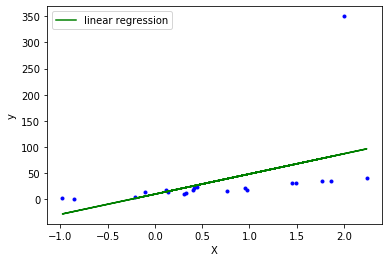

In [3]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
reg = LinearRegression()
reg.fit(X, y)

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

**ANSWER**

The whole set of data points *(except the altered datapoint)* clearly follows a linear trend with some noise. The slope and bias aren't properly estimated by the linear regression model. This is due to the aforementioned point that heavily influences the intercept term as well as the slope.

A squared loss in that situation isn't optimal when dealing with outliers since it penalizes too much such values (quadratic penalization) and gives too great "corrective" power to the outliers.

Regularization can be considered as a solution. L2 regularization penalizes too harshly large ("important") coefficients which produces more distributed and homogeneous models as opposed to L1 regularization which produces sparisity in the regression coefficients. 

A possible solution is to find common ground between the two, and to produce a loss function that has benefits of both types.

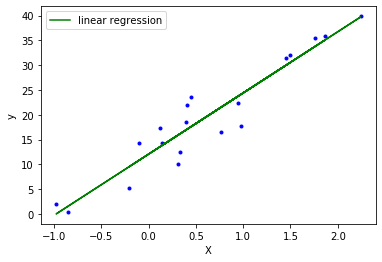

In [4]:
# The outliers cause this, we need somthing that is robust to outliers

X1 = X[y<50]
y1 = y[y<50]

# Fit the model
reg = LinearRegression()
reg.fit(X1, y1)

# Visualize the model
x = X1[:, 0]
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y1, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

## Part 1: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [5]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$</li>
    </ul>
</div>

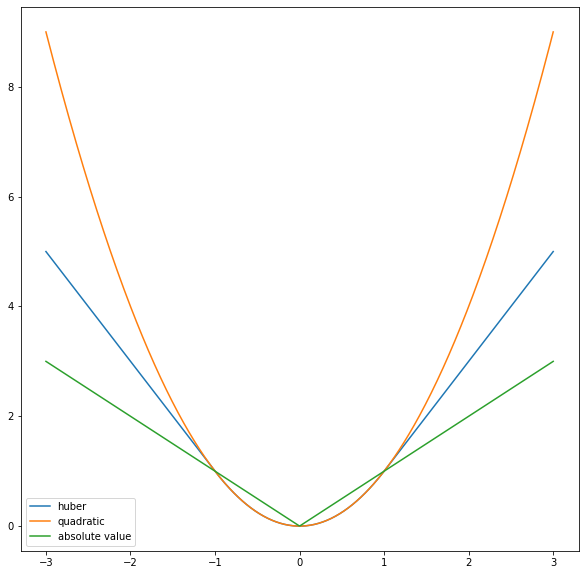

In [6]:
### TODO
t = np.linspace(-3., 3., 600)
hub = huber(t)
quad = t*t
absl = abs(t)
plt.figure(figsize=(10,10))
plt.plot(t, hub, label='huber')
plt.plot(t, t*t, label='quadratic')
plt.plot(t, abs(t), label='absolute value')
plt.legend()
plt.show()
### END TODO

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value of for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

**ANSWER**

- **Proving convexity of $H_\epsilon(x)$ :**

A sufficient condition for convexity is the function is differentiable on $\mathbb{R}$ and $f^\prime (x) \geq 0$ for all $x \in \mathbb{R}$.

- **Continuity**

On $]-\infty; -\epsilon]$: $H_\epsilon(x) = -2 \epsilon x - \epsilon^2 \implies \lim_{x \to -\epsilon^-} H_\epsilon(x) = \epsilon ^2$

On $]-\epsilon; \epsilon[$ we have $H_\epsilon(x) = x^2 \implies \lim_{x \to -\epsilon^+} H_\epsilon(x) = \epsilon ^2$ and $ \lim_{x \to \epsilon^-} H_\epsilon(x) = \epsilon ^2$

On $[\epsilon; +\infty[$ we have $H_\epsilon(x) = 2 \epsilon x - \epsilon^2  \implies \lim_{x \to \epsilon^+} H_\epsilon(x) = \epsilon ^2$

- $H_\epsilon(x)$ is continuous in $\mathbb{R}.$


- **First  and second derivatives**

On $]-\infty; -\epsilon]$ $H_\epsilon'(x) = -2\epsilon$ and $H_\epsilon''(x) = 0 \geq 0$.

On $]-\epsilon; \epsilon[$ $H_\epsilon'(x) = 2x$ and $H_\epsilon''(x) = 2 \geq 0$.

On $[\epsilon; +\infty[$ $H_\epsilon'(x) = 2\epsilon$ and $H_\epsilon''(x) = 0 \geq 0$.

*$H_\epsilon(x)$ is twice differentiable and its second derivative is always positive, so $H_\epsilon(x)$ is convex.* 

- **Proving the smoothness of $H_\epsilon(x)$ :**

Visually, the Huber function is upper-bounded by $f(x) = x^2$ on $\mathbb{R}$.

 - On $]-\infty; -\epsilon]$ and on $[\epsilon; +\infty[$ the gradient of the Huber function is constant. The function is therefore smooth with a Lipchistz constant $L = 0$.

 - On $]-\epsilon; \epsilon[$ the gradient is $H_\epsilon(x) = 2x$ and the Lipchitz constant is therefore 2.

Now, let $x, y \in \mathbb{R}$. We examine $|H_\epsilon'(x) - H_\epsilon'(y)|$.

* Case 1: $ x $ and $ y $ are in the same interval, we can see that $|H_\epsilon'(x) - H_\epsilon'(y)| \leq 2|x-y|$.

* Case 2: $x \in ]-\infty; \epsilon]$ and $y \in [\epsilon; +\infty[$ :

    \begin{equation}
            | H_\epsilon'(x) - H_\epsilon'(y) | = | -2 \epsilon - 2 \epsilon | = 4 \epsilon \leq 2 |x-y|,
    \end{equation}

 since $|x-y| \geq 2 \epsilon$.

* Case 3: $x \in ]-\epsilon; \epsilon[$ and $y \in [\epsilon; +\infty[$ :

    \begin{equation}
                  | H_\epsilon'(x) - H_\epsilon'(y) | = |2x - 2 \epsilon| = 2(\epsilon - x) \leq 2(y-x) = 2 |x-y|.
    \end{equation}

The roles of $x$ and $y$ are interchangeable and $H_\epsilon'$ is symmetrical, so the remaining cases hold.

The Huber function is therefore smooth and we propose as Lipschitz constant $2$.

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

In [7]:
### TODO
def hub_grad (x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = 2 * x[mask]
    z[~mask] = 2 * epsilon * np.sign(x[~mask])
    return z

from scipy.optimize import check_grad
#checking grad using 1000 samples uniformely from [-3, 3]
print("average error on calculated gradient vs. scipy's fprime : {}".format(np.mean([check_grad(huber, hub_grad, np.random.uniform(-3,3,1)) for i in range(1000)])))
### END TODO


average error on calculated gradient vs. scipy's fprime : 5.551203781983816e-09


Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.</li>
    </ul>
</div>

- **L-BFGS-B**

The L1-norm isn't differentiable in 0. L-BFGS-B may not be the most suitable method in the case of a L1-regularization since the approximation of the inverse hessian might be off and therefore does not guarantee an optimal solution.

The L2-norm is a more suitable option. 
The regularization term is a quadratic (smooth, convex and diffentiable) and the Huber loss function twice-differentiable almost everywhere. The regularization term would make the Hessian matrix positive definite as opposed to positive semi-definite before regularization.
The quadratic approximation achieved by L-BFGS makes more sense in this case.


- **Gradient descent**

The sum of the Huber loss function (smooth) and L1-norm (non-smooth) is not smooth. It is not possible to directly use classical gradient descent using the L1-norm.

On the other hand, the Huber function and the L2-norm are smooth convex. Since the gradient is a linear application, the sum is also smooth and convex. We can therefore readily apply gradient descenct with the L2-norm.

- **Proximal gradient descent**

The Huber function is convex, L-smooth and twice-differentiable. The regularization term in both cases is convex. We can thus use a proximal gradient descent readily.

- **Coordinate gradient descent or proximal coordinate gradient descent**

The pre-requisites for gradient descent (respectively proximal gradient descent) are the same as those for coordinate gradient descent (respectively proximal coordinate gradient descent). That being said the same results hold.



<div class="alert alert-success">
    <b>QUESTION 5:</b>
    <ul>
    <li>
        Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.</li>
    </ul>
</div>

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

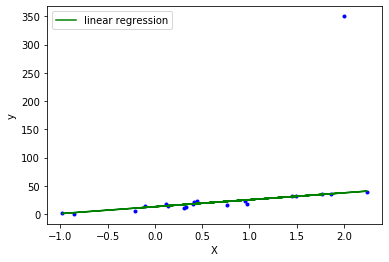

2.0

In [8]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01

def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def pobj_grad(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    grad_b = - np.mean(hub_grad(y - np.dot(X, params[1:]) -  params[0]))
    grad_w = - np.mean((hub_grad(y - np.dot(X, params[1:]) -  params[0])[:, np.newaxis] * X),axis=0)
    return np.concatenate([grad_b,grad_w],axis=None)


def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    # TODO
    params,_,_ = fmin_l_bfgs_b(pobj_l2, np.zeros(X.shape[1]+1), pobj_grad)
    # END TODO
    return params[0], params[1:]

# TODO  (for visualization)
b_hat, w_hat = huber_lbfgs_l2()

x = X[:, 0]
y_pred = w_hat * x + b_hat

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()
X[0, 0]
# END TODO

## Part 2: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [9]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [10]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 6a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

In [11]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step * grad(x, X,y,lbda,epsilon = grad_args), step, lbda = prox_args[0]) # Update x value based on the optimization formula
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 6b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [12]:
def prox_R2(params, reg=1.):
    # TODO
    params[1:] = params[1:]/(1+2*reg)
    # END TODO
    return params


def prox_R1(params, reg=1.):
    # TODO
    params[1:] = np.sign(params[1:]) * np.maximum(0., np.abs(params[1:]) - reg)
    # END TODO
    return params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

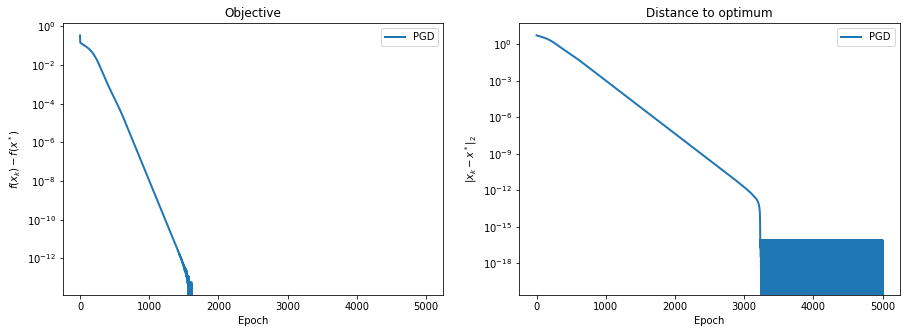

In [13]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)


# Set initial values of parameters to optimize
n_features = X.shape[1]
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 5000
lbda = 1.
epsilon = 1.


# TODO
def lipschitz_constant(X):
    max_svd = np.linalg.svd(X, full_matrices=True, compute_uv=True, hermitian=False)[1].max()
    L = (1/len(X))*max_svd**2
    return 1/L

step = lipschitz_constant(X)

x_min,_ = pgd(x_init, pobj_grad, prox_l2, step, n_iter=10000, store_every=-1,
        grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))
# END TODO

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, pobj_grad, prox_l2, step, n_iter,
                   grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

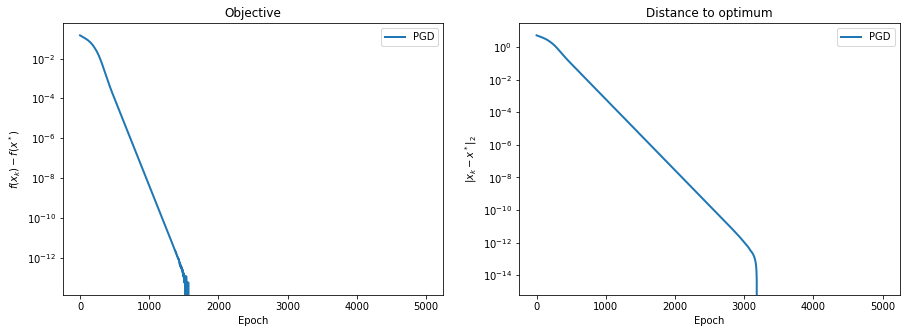

In [14]:
# Run PGD for L1

x_min,_ = pgd(x_init, pobj_grad, prox_l1, step, n_iter=10000, store_every=-1,
        grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, pobj_grad, prox_l1, step, n_iter,
                   grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [15]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = t_new =  1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        
        x_new = prox(y - step * grad(y, *grad_args), step, lbda = prox_args[0])
        t_new = (1+ np.sqrt( 1 + 4*t**2 )) / 2
        y = x_new + (t-1) * (x_new-x) / t_new
        
        x = x_new # keep the values to be used
        t = t_new
        
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

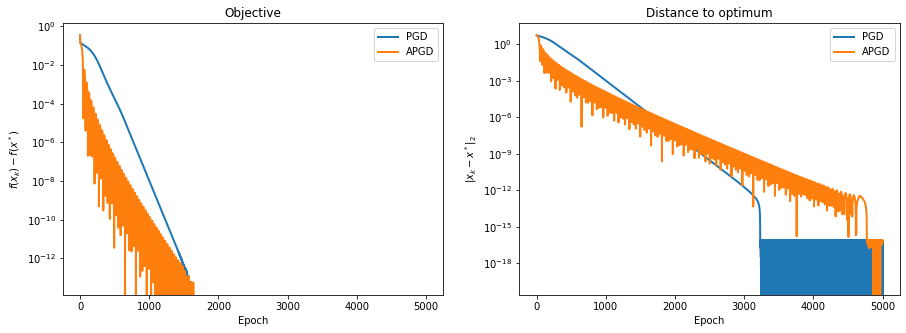

In [16]:
x_min,_ = apgd(x_init, pobj_grad, prox_l2, step, n_iter=10000, store_every=-1,
        grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l2.run(x_init, pobj_grad, prox_l2, step, n_iter,
                   grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

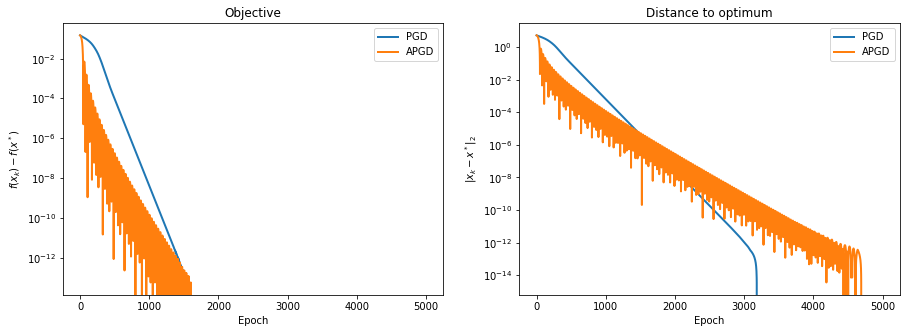

In [17]:
# TODO
x_min,_ = apgd(x_init, pobj_grad, prox_l1, step, n_iter=10000, store_every=-1,
        grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min, args=(X, y, lbda, epsilon))
monitor_apgd_l1.run(x_init, pobj_grad, prox_l1, step, n_iter,
                   grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [20]:
# TODO
def cd_grad(params, j, X=X, y=y, lbda=lbda, epsilon=epsilon):
    grad_b = - np.mean(hub_grad(y - np.dot(X, params[1:]) -  params[0]))
    grad_j = - np.dot(X[:,j], hub_grad(y - np.dot(X, params[1:]) -  params[0])) / len(X)
    return np.concatenate([grad_b,grad_j],axis=None)
    
def cgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):

    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        for j in range(len(x)-1):
            x[[0,j+1]] =  prox(x[[0,j+1]] - step * grad(x, j, *grad_args), step, lbda = prox_args[0])
            
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

# END TODO

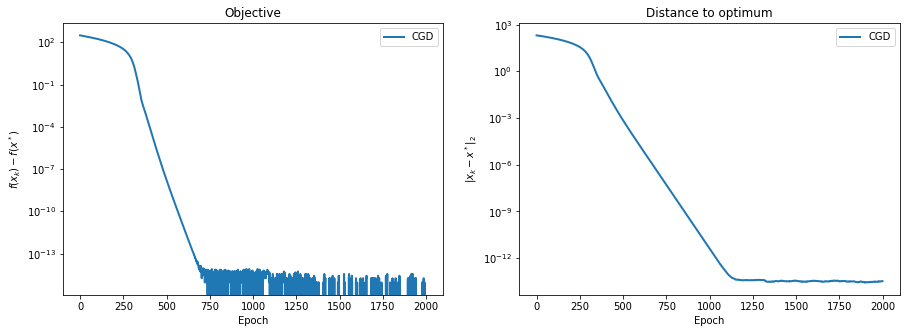

In [21]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)


# Set initial values of parameters to optimize
n_features = X.shape[1]
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 0.
epsilon = 1.

# TODO
step = 1/2

x_min,_ = cgd(x_init, cd_grad, prox_l2, step, n_iter=10000, store_every=-1, grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))
# END TODO

# Run PGD
monitor_cgd_l2 = monitor(cgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
monitor_cgd_l2.run(x_init, cd_grad, prox_l2, step, n_iter,
                   grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitors = [monitor_cgd_l2]
solvers = ["CGD"]
plot_epochs(monitors, solvers)

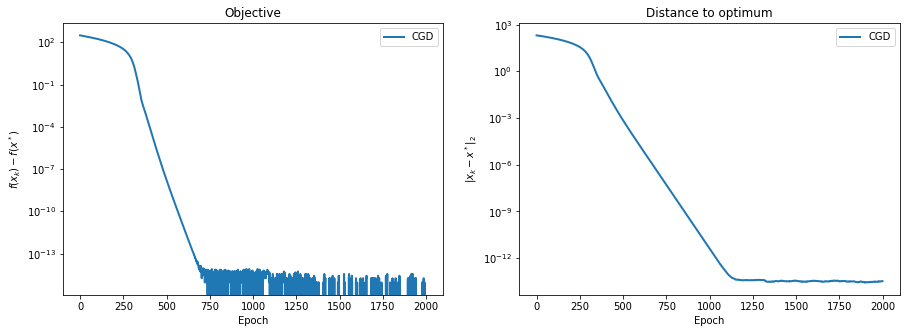

In [22]:
x_min,_ = cgd(x_init, cd_grad, prox_l1, step, n_iter=10000, store_every=-1,
        grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))
# END TODO

# Run PGD
monitor_cgd_l1 = monitor(cgd, pobj_l1, x_min, args=(X, y, lbda, epsilon))
monitor_cgd_l1.run(x_init, cd_grad, prox_l1, step, n_iter,
                   grad_args=(X, y, lbda, epsilon), prox_args=(lbda,))

monitors = [monitor_cgd_l1]
solvers = ["CGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

YOUR ANSWER HERE

# Part 3: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [23]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

,LNOx,LNOxEm,sqrtWS
193,4.457250,5.536489,0.856446
194,4.151827,5.513000,1.016612
195,3.834061,4.886994,1.095445
196,4.172848,5.138912,1.354068
197,4.322807,5.666518,1.204159


Now let's extract `X` and `y`

In [24]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

((8088, 2), (8088,))

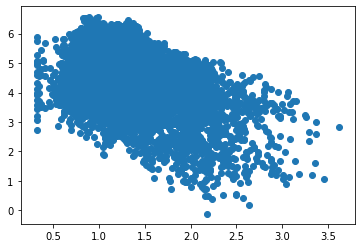

In [25]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [26]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd', step=1/2):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        self.step = lipschitz_constant(X)
        # TODO
        x = np.zeros(n_features+1)
        if self.solver=='pgd':
            if self.penalty=='l2':
                x,_ = pgd(x, pobj_grad, prox_l2, self.step, n_iter=self.max_iter, store_every=1, \
                            grad_args=(X, y, self.lbda, self.epsilon), prox_args=(self.lbda,))
            else:
                x,_ = pgd(x, pobj_grad, prox_l1, self.step, n_iter=self.max_iter, store_every=1, \
                            grad_args=(X, y, self.lbda, self.epsilon), prox_args=(self.lbda,))
        if self.solver=='apgd':
            if self.penalty=='l2':
                x,_ = apgd(x, pobj_grad, prox_l2, self.step, n_iter=self.max_iter, store_every=1, \
                            grad_args=(X, y, self.lbda, self.epsilon), prox_args=(self.lbda,))
            else:
                x,_ = apgd(x, pobj_grad, prox_l1, self.step, n_iter=self.max_iter, store_every=1, \
                            grad_args=(X, y, self.lbda, self.epsilon), prox_args=(self.lbda,))
        if self.solver=='pcd':
            if self.penalty=='l2':
                x,_ = cgd(x, cd_grad, prox_l2, self.step, n_iter=self.max_iter, store_every=1,
        grad_args=(X, y, self.lbda, self.epsilon), prox_args=(self.lbda,))
            else:
                x,_ = cgd(x, cd_grad, prox_l1, self.step, n_iter=self.max_iter, store_every=1, \
                            grad_args=(X, y, self.lbda, self.epsilon), prox_args=(self.lbda,))
                
                
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))

score_l2 = []
score_l1 = []

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))
    score_l2.append(-clf.score(X, y))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))
    score_l1.append(-clf.score(X, y))

Solver with L2: pgd   	-   MAE : 0.54898
Solver with L2: apgd   	-   MAE : 0.78175
Solver with L2: pcd   	-   MAE : 0.56328
Solver with L1: pgd   	-   MAE : 0.57922
Solver with L1: apgd   	-   MAE : 0.68833
Solver with L1: pcd   	-   MAE : 0.62742


<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [36]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# TODO
alpha = 1.
lasso = Lasso(alpha=alpha)
ridge = Ridge(alpha=alpha * len(X))

print(-cross_val_score(lasso, X, y, cv=3, scoring='neg_mean_absolute_error').mean())
print(-cross_val_score(ridge, X, y, cv=3, scoring='neg_mean_absolute_error').mean())

# END TODO

0.7257545612596622
0.5986726104180415


In [39]:
score_l2
for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver, epsilon=1000.)
    clf.fit(X, y)
    score_l2.append(-clf.score(X, y))
np.mean(score_l2)

0.5704480283623613